In [139]:
# - Train/test split
# - Models: Logistic Regression (linear classifier) & Random Forest
# - Compare accuracies + full metrics
# - Visuals: histograms, class balance, ROC, confusion matrices, feature importance
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [140]:
# -------------------- Config --------------------
CSV_PATH = "loan_applications.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.2

# -------------------- Load ----------------------
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(
        f"{CSV_PATH} not found. Place your CSV next to this script or update CSV_PATH."
    )

df = pd.read_csv(CSV_PATH)

#Read Top 5 Rows
df.head()

,applicant_id,age,gender,income,loan_amount,loan_term_months,employment_years,credit_score,existing_loans_count,debt_to_income_ratio,collateral_value,region,loan_purpose,approval_status
0,1,59,Male,146944,47520,12,20,804,0,0.30,47574,South,Home,Approved
1,2,49,Female,132726,69772,60,9,593,4,0.50,43391,West,Personal,Approved
2,3,35,Male,101974,63762,60,4,576,0,0.06,53664,West,Home,Approved
3,4,63,Female,125947,55106,12,35,737,2,0.49,67384,West,Personal,Approved
4,5,28,Male,46399,30559,12,5,406,3,0.93,31027,South,Home,Rejected


In [141]:
# -------------------- Quick EDA -----------------
print("\n=== Basic Info ===")
print("Shape:", df.shape)
print("\nMissing values:\n", df.isna().sum())
print("\nApproval distribution:\n", df["approval_status"].value_counts())
print("\nNumeric summary:\n", df.describe())


=== Basic Info ===
Shape: (500, 14)

Missing values:
 applicant_id            0
age                     0
gender                  0
income                  0
loan_amount             0
loan_term_months        0
employment_years        0
credit_score            0
existing_loans_count    0
debt_to_income_ratio    0
collateral_value        0
region                  0
loan_purpose            0
approval_status         0
dtype: int64

Approval distribution:
 approval_status
Approved    350
Rejected    150
Name: count, dtype: int64

Numeric summary:
        applicant_id        age         income   loan_amount  loan_term_months  \
count    500.000000  500.00000     500.000000    500.000000        500.000000   
mean     250.500000   43.53600   85760.418000  42074.540000         37.224000   
std      144.481833   13.02613   37363.191902  21228.411607         17.121218   
min        1.000000   21.00000   20060.000000   5281.000000         12.000000   
25%      125.750000   32.00000   53638.000000

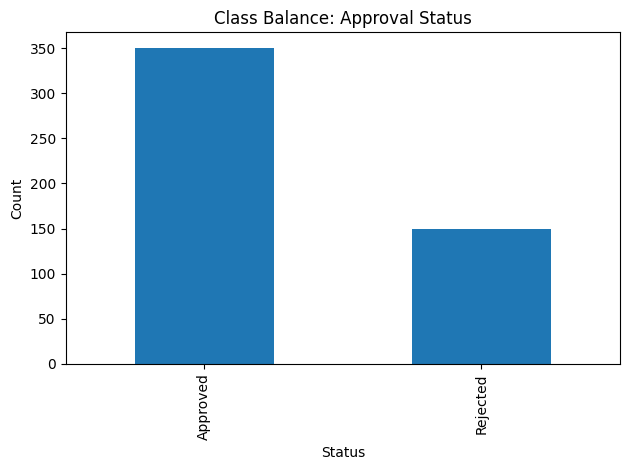

In [142]:
# Visual: class balance
plt.figure()
df["approval_status"].value_counts().plot(kind="bar")
plt.title("Class Balance: Approval Status")
plt.xlabel("Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [143]:
# Visual: histograms for key numeric vars
numeric_all = [
    "age", "income", "loan_amount", "loan_term_months", "employment_years",
    "credit_score", "existing_loans_count", "debt_to_income_ratio", "collateral_value"
]

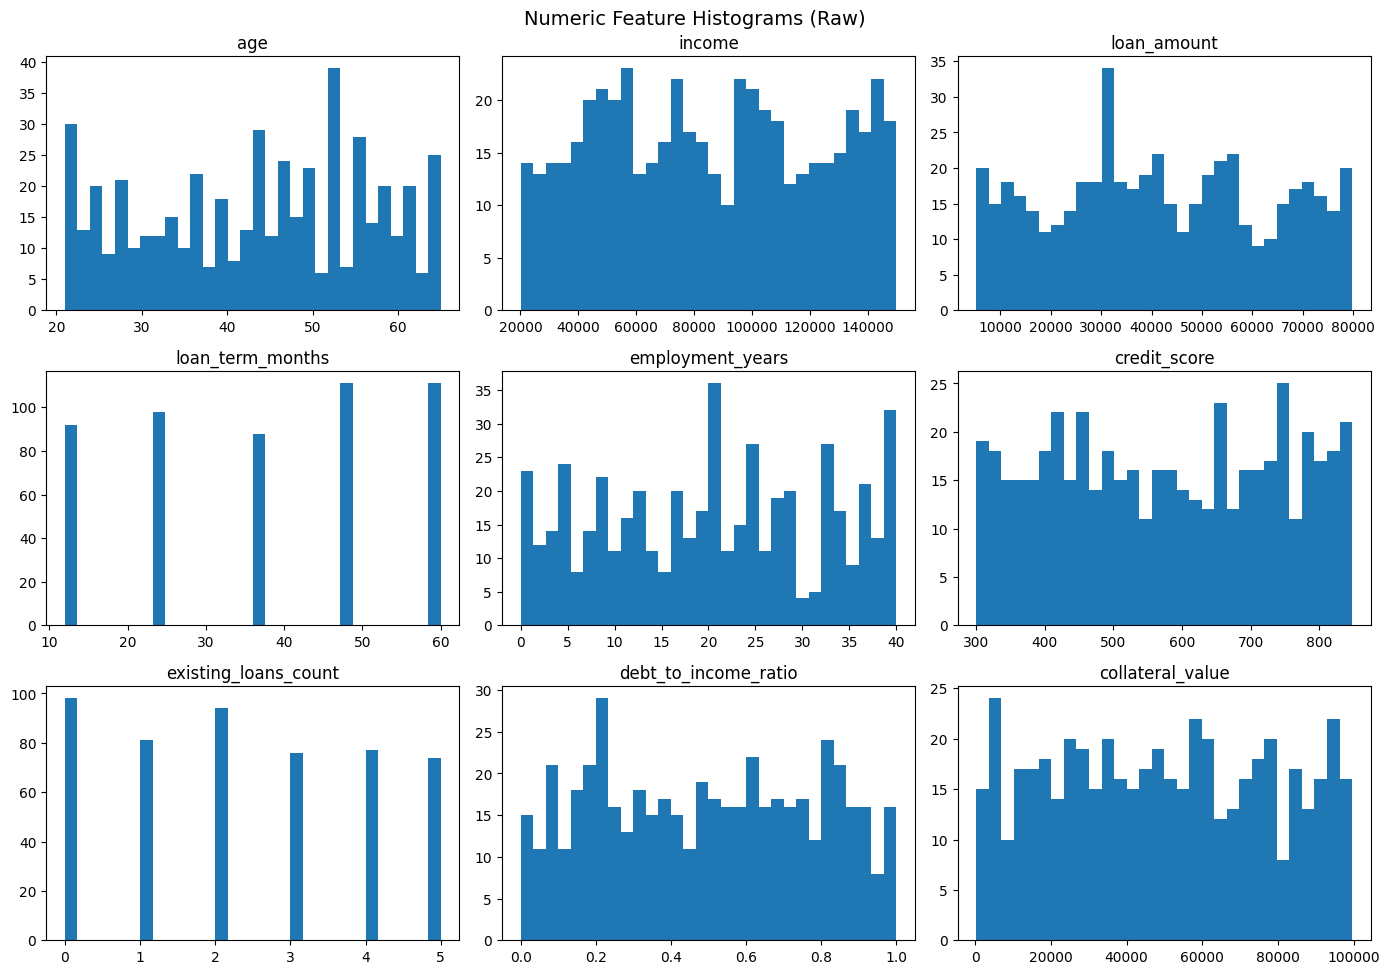

In [144]:
n_cols = 3
n_rows = int(np.ceil(len(numeric_all) / n_cols))
plt.figure(figsize=(14, n_rows * 3.2))
for i, col in enumerate(numeric_all, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(df[col], bins=30)
    plt.title(col)
    plt.tight_layout()
plt.suptitle("Numeric Feature Histograms (Raw)", y=1.01, fontsize=14)
plt.show()

In [145]:
# -------------------- Outlier Treatment: income (IQR) -------------
Q1 = df["income"].quantile(0.25)
Q3 = df["income"].quantile(0.75)
IQR = Q3 - Q1
low, high = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
before = len(df)
df = df[(df["income"] >= low) & (df["income"] <= high)].copy()
after = len(df)
print(f"\nRemoved {before - after} rows as income outliers (kept {after}).")


Removed 0 rows as income outliers (kept 500).


In [147]:
# -------------------- Target --------------------
df["approved"] = (df["approval_status"].str.lower() == "approved").astype(int)

# -------------------- Features ------------------
categorical = ["gender", "region", "loan_purpose"]
numeric = [
    "age", "income", "loan_amount", "loan_term_months", "employment_years",
    "credit_score", "existing_loans_count", "debt_to_income_ratio", "collateral_value"
]

In [148]:
# One-hot encode categoricals
df = pd.get_dummies(df, columns=categorical, drop_first=True)

# Split X/y
X = df.drop(columns=["approval_status", "approved"])
y = df["approved"].values

In [149]:
# -------------------- Train/Test Split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

In [150]:
# -------------------- Scaling (Z-score) ----------
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()
X_train_scaled[numeric] = scaler.fit_transform(X_train[numeric])
X_test_scaled[numeric]  = scaler.transform(X_test[numeric])

In [151]:
# -------------------- Models ---------------------
# NOTE: "Linear regression" is not appropriate for classification.
# We use *Logistic Regression* as the linear classifier.
log_reg = LogisticRegression(max_iter=1000, n_jobs=None)
rf = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE)

In [152]:
# Fit
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [153]:
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

In [154]:
# Predict
proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]
pred_lr = (proba_lr >= 0.5).astype(int)

proba_rf = rf.predict_proba(X_test_scaled)[:, 1]
pred_rf = (proba_rf >= 0.5).astype(int)

In [155]:
def report(name, y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC AUC  : {auc:.4f}")
    return acc

acc_lr = report("Logistic Regression (linear)", y_test, pred_lr, proba_lr)
acc_rf = report("Random Forest", y_test, pred_rf, proba_rf)

print("\n>>> Accuracy comparison:")
print(f"Logistic Regression: {acc_lr:.4f}")
print(f"Random Forest      : {acc_rf:.4f}")


=== Logistic Regression (linear) ===
Accuracy : 0.9800
Precision: 0.9857
Recall   : 0.9857
F1-score : 0.9857
ROC AUC  : 0.9995

=== Random Forest ===
Accuracy : 0.9400
Precision: 0.9211
Recall   : 1.0000
F1-score : 0.9589
ROC AUC  : 0.9848

>>> Accuracy comparison:
Logistic Regression: 0.9800
Random Forest      : 0.9400


<Figure size 640x480 with 0 Axes>

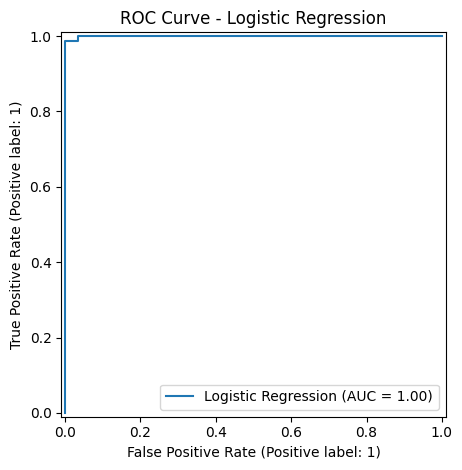

<Figure size 640x480 with 0 Axes>

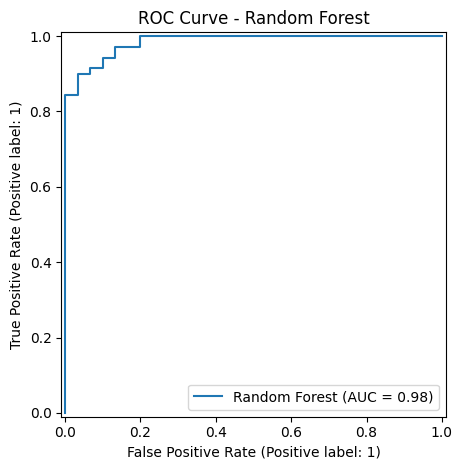

In [156]:
# -------------------- ROC Curves -----------------
plt.figure()
RocCurveDisplay.from_predictions(y_test, proba_lr, name="Logistic Regression")
plt.title("ROC Curve - Logistic Regression")
plt.tight_layout()
plt.show()

plt.figure()
RocCurveDisplay.from_predictions(y_test, proba_rf, name="Random Forest")
plt.title("ROC Curve - Random Forest")
plt.tight_layout()
plt.show()

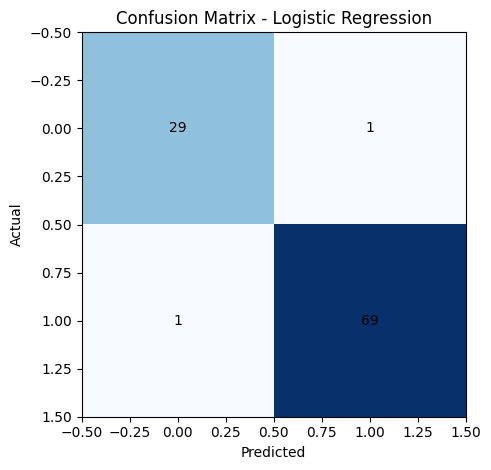

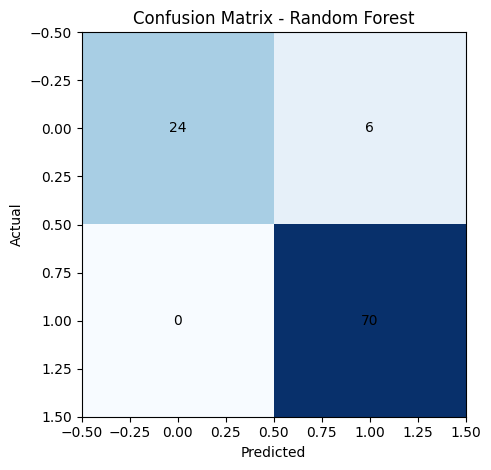

In [157]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.tight_layout()
    plt.show()

plot_cm(y_test, pred_lr, "Confusion Matrix - Logistic Regression")
plot_cm(y_test, pred_rf, "Confusion Matrix - Random Forest")

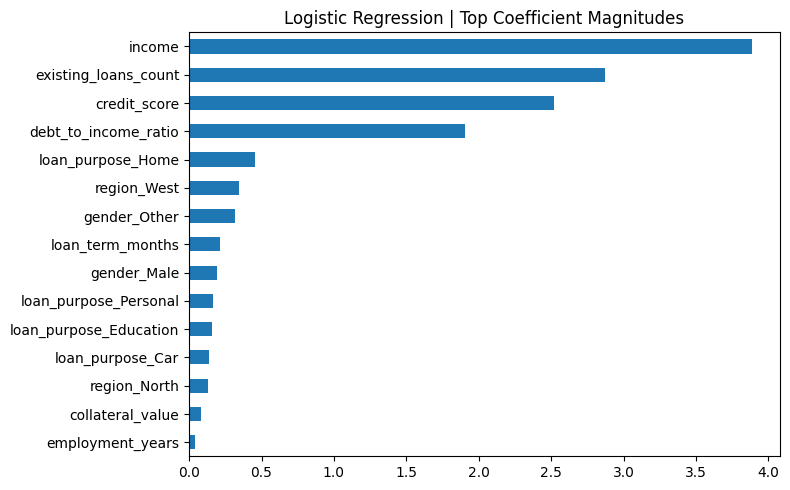

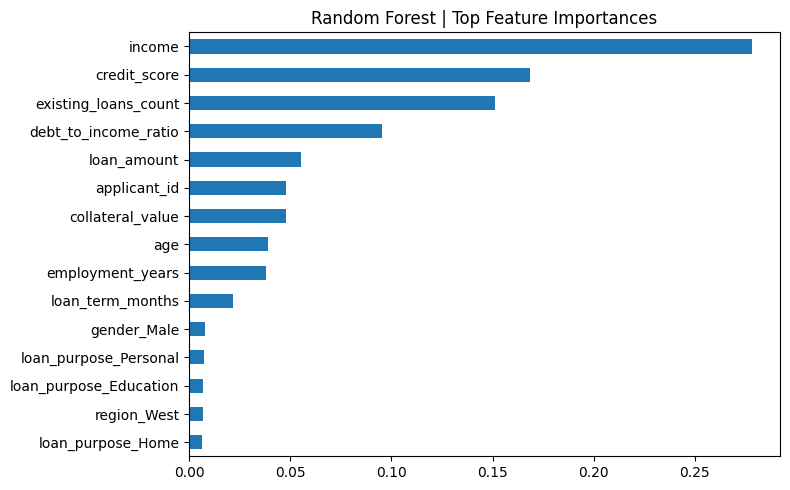

In [158]:
# -------------------- Feature Importance --------
# Logistic Regression: top coefficients by magnitude
lr_coef = pd.Series(log_reg.coef_.ravel(), index=X_train_scaled.columns)
lr_top = lr_coef.abs().sort_values(ascending=False).head(15)

plt.figure(figsize=(8, 5))
lr_top.sort_values().plot(kind="barh")
plt.title("Logistic Regression | Top Coefficient Magnitudes")
plt.tight_layout()
plt.show()

# Random Forest importances
rf_imp = pd.Series(rf.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
rf_imp.head(15).sort_values().plot(kind="barh")
plt.title("Random Forest | Top Feature Importances")
plt.tight_layout()
plt.show()

In [159]:
# Comment out if not needed.
new_applicants = pd.DataFrame([
    {
        "age": 32, "income": 95000, "loan_amount": 20000, "loan_term_months": 36,
        "employment_years": 6, "credit_score": 760, "existing_loans_count": 1,
        "debt_to_income_ratio": 0.22, "collateral_value": 30000,
        "gender": "Male", "region": "North", "loan_purpose": "Car"
    },
    {
        "age": 47, "income": 38000, "loan_amount": 50000, "loan_term_months": 60,
        "employment_years": 3, "credit_score": 560, "existing_loans_count": 2,
        "debt_to_income_ratio": 0.62, "collateral_value": 10000,
        "gender": "Female", "region": "South", "loan_purpose": "Personal"
    },
    {
        "age": 47, "income": 100000, "loan_amount": 50000, "loan_term_months": 60,
        "employment_years": 3, "credit_score": 260, "existing_loans_count": 12,
        "debt_to_income_ratio": 0.62, "collateral_value": 10000,
        "gender": "Female", "region": "South", "loan_purpose": "Personal"
    }
])

# Align dummy columns with training set
new_applicants = pd.get_dummies(new_applicants, columns=["gender", "region", "loan_purpose"], drop_first=True)
for col in X_train.columns:
    if col not in new_applicants.columns:
        new_applicants[col] = 0
new_applicants = new_applicants[X_train.columns]

# Scale numeric columns with train scaler
new_applicants[numeric] = scaler.transform(new_applicants[numeric])

# Predict with both models
new_lr = (log_reg.predict_proba(new_applicants)[:, 1] >= 0.5).astype(int)
new_rf = (rf.predict_proba(new_applicants)[:, 1] >= 0.5).astype(int)

pred_df = pd.DataFrame({
    "Model": ["LogReg"] * len(new_lr),
    "Predicted": ["Approved" if v == 1 else "Rejected" for v in new_lr]
})
pred_df_rf = pd.DataFrame({
    "Model": ["RandForest"] * len(new_rf),
    "Predicted": ["Approved" if v == 1 else "Rejected" for v in new_rf]
})
print("\nPredictions for sample new applicants:")
print(pd.concat([pred_df, pred_df_rf], axis=1))


Predictions for sample new applicants:
    Model Predicted       Model Predicted
0  LogReg  Approved  RandForest  Approved
1  LogReg  Rejected  RandForest  Rejected
2  LogReg  Rejected  RandForest  Rejected
